<a href="https://colab.research.google.com/github/GR-TheArchitect/Colab_Public/blob/master/Anomalies_Detection_with_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

On my LinkedIn site (https://www.linkedin.com/in/jaffar-hussain-3414383/detail/recent-activity/shares/), I demonstrated how the COVID19 impact on the financial industry could’ve been predicted and thus planned for had banks been using a market-driven model for computing default probabilities. The demonstrations in my LinkedIn articles were accomplished using a step-wise regression model which uses forward and backward error propagation techniques to select the smallest and most relevant set of independent features for the model. Here I present a different approach to address the following question: does the financial impact of COVID19 on the banking industry in the USA represent a financial anomaly; a black swan? The approach used here is Convolutional Neural Networks (CNNs). The dataset covers the period from January 2007 to April 2020. The CNN is trained on data from January 2007 till about August 2013. I should emphasize that using CNN for anamoly detection in this case is only for demonstration purposes. The main technique which plays a part here is using equity prices and options-implied volatility to infer the expected losses of each bank. It's this technique that is responsible for capturing the tail distribuiton of expected losses.

**Libraries**

In [1]:
import numpy as np #python lib for numerical functions
%matplotlib inline
import matplotlib #for plotting graphs
import matplotlib.pyplot as plt
from matplotlib import style #to use different styles while plotting
from matplotlib import dates as md
import pandas as pd #to use data frames
from pandas import DataFrame #dataframes
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import sklearn #python lib for linear regression and other models
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron

import altair as alt #used for graphing

**Data Download from my GitHub Site**

In [2]:
import os

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/GR-TheArchitect/Colab_Public/master/"
CDS_PATH = os.path.join("datasets", "cdsinfo")
CDS_URL = DOWNLOAD_ROOT + "datasets/ist/"

The data is composed of high-quality information on the default probabilities of US-based banks. The default probabilities are derived from the equtiy prices of each bank and its options-implied volatility using a merton-type model developed by me. The model is very similar to the industry-standard CreditGrades model.

In [3]:
def load_cds_data(cds_path=CDS_URL):
    csv_path = os.path.join(cds_path, "USA_Banking_Industry.csv")
    return pd.read_csv(csv_path)

In [4]:
cdsinfo = load_cds_data()

**Data Display:** the main focus will be on the Industry Expected Losses Column which represents a capital-weighted expected loss rate for the banks combined. The banks used in this study are indicated by their equity tickers. PD stands for probability of default, and DtD stands for distance to default. These two metrics are the most widely used metrics for modeling market-driven credit risk and tail-risk. 

In [5]:
cdsinfo.head()

Date  ...  Industry Market Value of Assets
0  1/3/2007  ...                      5084.230171
1  1/4/2007  ...                      5081.392325
2  1/5/2007  ...                      5076.259248
3  1/8/2007  ...                      5086.023619
4  1/9/2007  ...                      5080.866693

[5 rows x 49 columns]

**Displaying the data and data type.**

In [6]:
print(cdsinfo.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3349 entries, 0 to 3348
Data columns (total 49 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Date                                 3349 non-null   object 
 1   GS Expected Loss                     3349 non-null   float64
 2   GS Share Price                       3349 non-null   float64
 3   GS 6M-Implied Volatility             3349 non-null   float64
 4   GS Market-Implied 1-Yr PD            3349 non-null   float64
 5   GS Option-Implied DtD                3349 non-null   float64
 6   WFC Expected Loss                    3349 non-null   float64
 7   WFC Share Price                      3349 non-null   float64
 8   WFC 6M-Implied Volatility            3349 non-null   float64
 9   WFC Market-Implied 1-Yr PD           3349 non-null   float64
 10  WFC Option-Implied DtD               3349 non-null   float64
 11  VIX Index                     

**Visualizing the Industry Expected Losses (ECL).** ECL distributions usually follow a beta distribution. The distribution of ECL does not directly address the anaomlies which reside in the tail of the distribution. Building a tail distribution would require the use of more sophisticated techniques such as Extreme Value Theory and Generative Adversarial Networks (GANs).

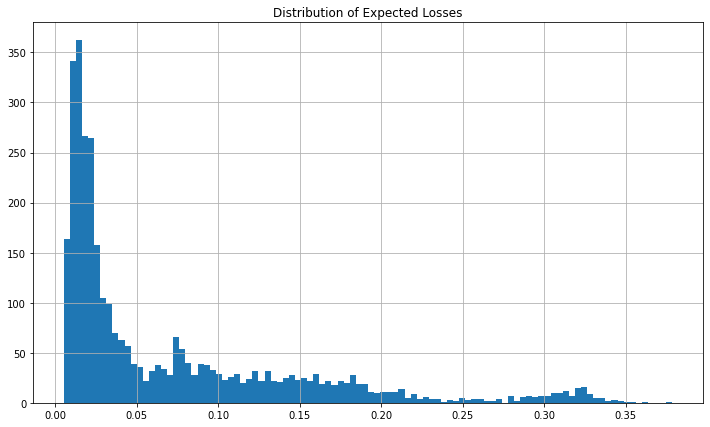

In [7]:
cdsinfo['Industry Expected Losses'].hist(bins=100, figsize=(12,7))
plt.title("Distribution of Expected Losses")
plt.show()

In [8]:
dataset = cdsinfo.copy()

The graph below demonstrates the non-linearity of ECLs, when ECLs are plotted against the level of the S&P 500 equity index. This behavior has been studied extensively. This is not to say that ECLs cannot be modelled with linear models; they can and did show that in my LinkedIn article. However, it makes the selection of the linear-model variables of utmost importance. The variables must have a strong economic relation with the ECLs. 

In [9]:
alt.Chart(dataset).mark_point(color='blue').encode(
    x='S&P 500 Total Market Capitalization',
    y='Industry Expected Losses',
    size='VIX Index',
    tooltip=['S&P 500 Total Market Capitalization',
             'Industry Expected Losses']
).properties(
    width=700,
    height=700,
).interactive()

alt.Chart(...)

In [10]:
dataset['Industry Expected Losses'].describe()

count    3349.000000
mean        0.070500
std         0.077888
min         0.005141
25%         0.016103
50%         0.031540
75%         0.103225
max         0.378568
Name: Industry Expected Losses, dtype: float64

**Preparing the training and testing sets**

In [11]:
train_set, test_set = train_test_split(dataset, test_size=0.4998, shuffle=False)

In [12]:
print(train_set['Industry Expected Losses'].describe())

count    1675.000000
mean        0.118997
std         0.081907
min         0.014071
25%         0.054918
50%         0.098684
75%         0.161115
max         0.378568
Name: Industry Expected Losses, dtype: float64


**Visualizing the training set**

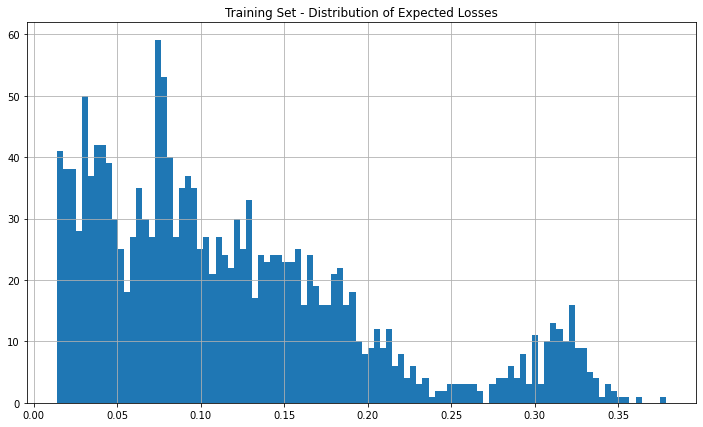

In [13]:
train_set['Industry Expected Losses'].hist(bins=100, figsize=(12,7))
plt.title("Training Set - Distribution of Expected Losses")
plt.show()

In [14]:
print(test_set['Industry Expected Losses'].describe())

count    1674.000000
mean        0.021975
std         0.026770
min         0.005141
25%         0.011535
50%         0.016234
75%         0.022913
max         0.291185
Name: Industry Expected Losses, dtype: float64


**Visualizing the testing set**

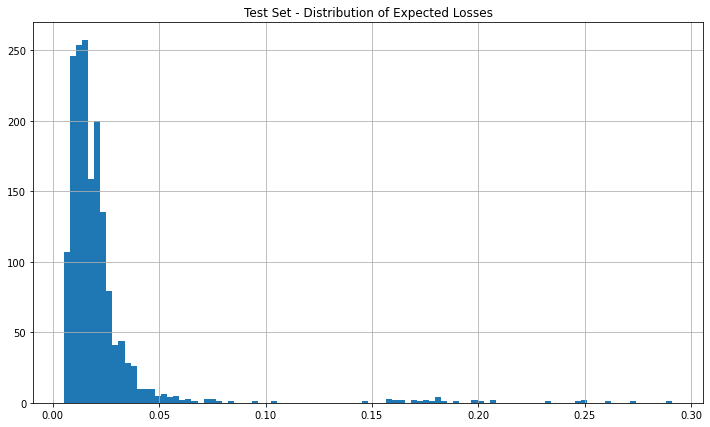

In [15]:
test_set['Industry Expected Losses'].hist(bins=100, figsize=(12,7))
plt.title("Test Set - Distribution of Expected Losses")
plt.show()

The training set extends from January 2007 to around August 2013

Text(0.5, 1.0, 'Training Set - Industry Expected Losses')

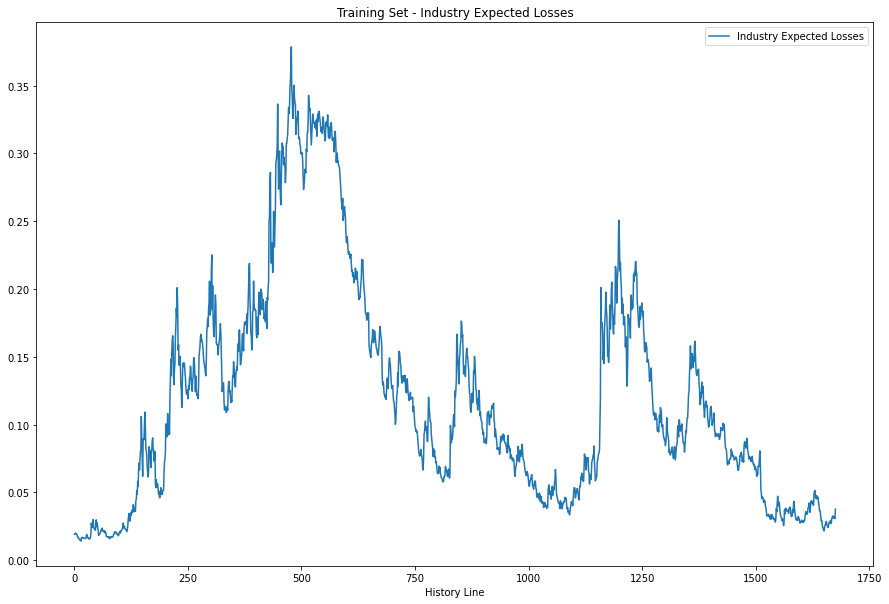

In [16]:
train_set.plot(kind="line", x="History Line", y="Industry Expected Losses", figsize=(15, 10))
plt.title("Training Set - Industry Expected Losses")

The graph below shows the sudden jump in expected losses due to COVID19.

Text(0.5, 1.0, 'Test Set - Industry Expected Losses')

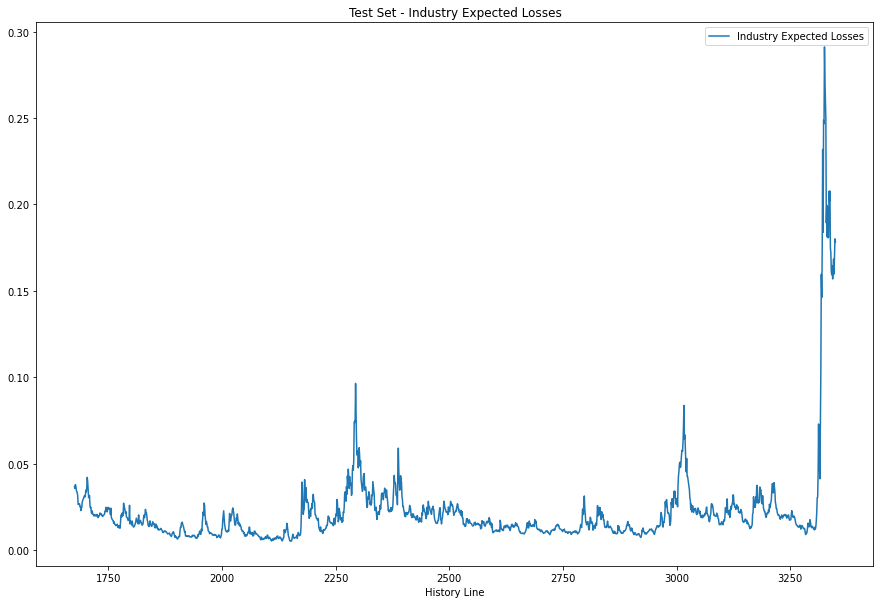

In [17]:
test_set.plot(kind="line", x="History Line", y="Industry Expected Losses", figsize=(15, 10))
plt.title("Test Set - Industry Expected Losses")

In [18]:
in_sample = train_set.copy() #renaming the training set to in_sample


In [20]:
print(in_sample.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1675 entries, 0 to 1674
Data columns (total 49 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Date                                 1675 non-null   object 
 1   GS Expected Loss                     1675 non-null   float64
 2   GS Share Price                       1675 non-null   float64
 3   GS 6M-Implied Volatility             1675 non-null   float64
 4   GS Market-Implied 1-Yr PD            1675 non-null   float64
 5   GS Option-Implied DtD                1675 non-null   float64
 6   WFC Expected Loss                    1675 non-null   float64
 7   WFC Share Price                      1675 non-null   float64
 8   WFC 6M-Implied Volatility            1675 non-null   float64
 9   WFC Market-Implied 1-Yr PD           1675 non-null   float64
 10  WFC Option-Implied DtD               1675 non-null   float64
 11  VIX Index                     

In [21]:
in_sample["Industry Expected Losses"]

0       0.019174
1       0.019546
2       0.019929
3       0.019456
4       0.019590
          ...   
1670    0.032511
1671    0.031528
1672    0.031560
1673    0.030656
1674    0.037674
Name: Industry Expected Losses, Length: 1675, dtype: float64

Standardizing the dataset by weighing each data point by the standard deviation of the dataset. This is a good practice in general though it is not necessary here. A more important analysis would focus on the study of the residuals.

In [25]:
def get_value_from_df(df):
    return df["Industry Expected Losses"].values.tolist()

def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std

y_in = in_sample["Industry Expected Losses"].copy()
training_value = get_value_from_df(in_sample)

training_val, training_m, training_s = normalize(y_in)
training_value, training_mean, training_std = normalize(training_value)

print(training_mean, training_std)
len(training_value)

0.11899658095044777 0.08188258875502352


1675

Below is a graph of the same ECL distribution after standardizing the training dataset. I should probably say something here of a technical nature. Anamoly detection is a fine art! Anamolies do not form a part of the main central data; instead they reside in the tail of the distribution. Thus anamoly detection and modeling is really about re-building the tail of the distribution (not the center). Technically the graph below is a mixture of two distributions: one distribution conveys the nature of the central dataset while the other distribution contains the tail data points.

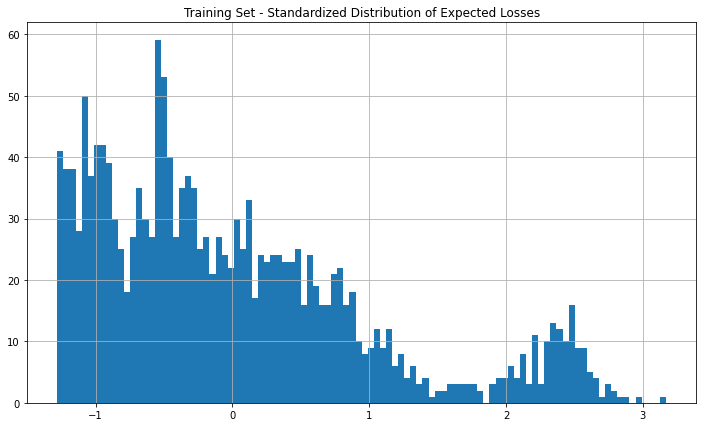

In [24]:
training_val.hist(bins=100, figsize=(12,7))
plt.title("Training Set - Standardized Distribution of Expected Losses")
plt.show()

In [26]:
training_value #the standardized dataset

array([-1.21908907, -1.21455559, -1.20987202, ..., -1.06783295,
       -1.07886507, -0.99316494])

**Preparing the training dataset for a CNN. Alternatively one could use a recurrent neural network (RNN).** It should be noted here that financial data series, and specifically ECLs, exhibit a number of extensively studied statistical characteristics related to memory such as the well-known phenomenon of volatility clustering  which would suggest the use of one neural network or another. For ECLs, RNN is an interesting choice which deserves a thorough study. 

When dealing with time series or sequences in general, the input features are generally represented as 3D arrays of shape [batch size, time step, dimensionality]. The data we have is univariate and so the dimensionality is 1. 

In [30]:
TIME_STEPS = 288 #specifying the frames

#creating sequences of the training dataset..Credit goes to pavithrasv
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    # Convert 2D sequences into 3D as we will be feeding this into
    # a convolutional layer.
    return np.expand_dims(output, axis=2)


x_train = create_sequences(training_value) #x_train contains 1387 time series, each of length 288. the input_shape is [288, 1]
print("Training input shape: ", x_train.shape)

Training input shape:  (1387, 288, 1)


In [28]:
x_train

array([[[-1.21908907],
        [-1.21455559],
        [-1.20987202],
        ...,
        [ 0.33051681],
        [ 0.30585897],
        [ 0.27478427]],

       [[-1.21455559],
        [-1.20987202],
        [-1.21564758],
        ...,
        [ 0.30585897],
        [ 0.27478427],
        [ 0.23226087]],

       [[-1.20987202],
        [-1.21564758],
        [-1.21400771],
        ...,
        [ 0.27478427],
        [ 0.23226087],
        [ 0.20722396]],

       ...,

       [[-0.0411798 ],
        [-0.09576076],
        [-0.16740733],
        ...,
        [-1.07481886],
        [-1.05621731],
        [-1.06822447]],

       [[-0.09576076],
        [-0.16740733],
        [-0.08878366],
        ...,
        [-1.05621731],
        [-1.06822447],
        [-1.06783295]],

       [[-0.16740733],
        [-0.08878366],
        [-0.03782995],
        ...,
        [-1.06822447],
        [-1.06783295],
        [-1.07886507]]])

**Building 1D Convolutional Layers:** a 1D convolutional layer slides several kernels across a sequency, producing a 1D feature map per kernal. Each kernal learns to detect a single very short sequential pattern. If you use 10 kernals, then the layer's output will be composed of 10 1-dimensional sequences of the same length. If you use a 1D convolutional layer with a stride of 1 and "same" padding, then the output sequence will have the same length as the input sequence. But if you use "valid" padding or a stride greater than 1, then the output sequence will be shorter than the input sequence. In this example, the 1D layer will downsample the input sequence by a factor of 2, using a stride of 2. So the kernal size is larger than the stride, so all inputs will be used to computer the layer's output, and the model can therefore learn to preserve useful information.

In [31]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

In [32]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
10/10 [==============================] - 1s 108ms/step - loss: 0.8776 - val_loss: 0.5025
Epoch 2/50
10/10 [==============================] - 1s 76ms/step - loss: 0.3422 - val_loss: 0.3465
Epoch 3/50
10/10 [==============================] - 1s 80ms/step - loss: 0.1464 - val_loss: 0.0165
Epoch 4/50
10/10 [==============================] - 1s 75ms/step - loss: 0.0776 - val_loss: 0.0148
Epoch 5/50
10/10 [==============================] - 1s 78ms/step - loss: 0.0588 - val_loss: 0.0231
Epoch 6/50
10/10 [==============================] - 1s 78ms/step - loss: 0.0515 - val_loss: 0.0158
Epoch 7/50
10/10 [==============================] - 1s 77ms/step - loss: 0.0472 - val_loss: 0.0153
Epoch 8/50
10/10 [==============================] - 1s 78ms/step - loss: 0.0441 - val_loss: 0.0130
Epoch 9/50
10/10 [==============================] - 1s 75ms/step - loss: 0.0414 - val_loss: 0.0126
Epoch 10/50
10/10 [==============================] - 1s 80ms/step - loss: 0.0387 - val_loss: 0.0122
Epoch 11

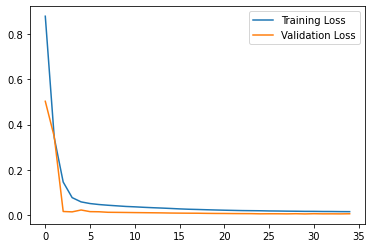

In [33]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

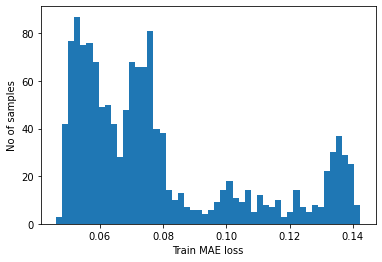

Reconstruction error threshold:  0.142373829399946


In [34]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)


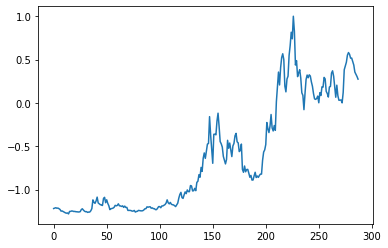

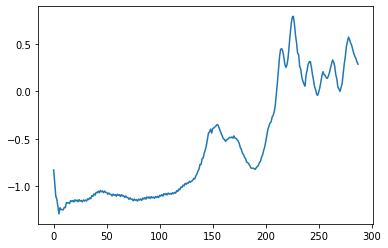

In [35]:
plt.plot(x_train[0])
plt.show()
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
x_train

In [36]:
out_sample = test_set.copy()

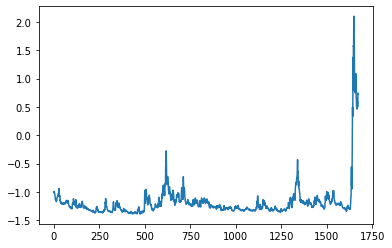

Test input shape:  (1386, 288, 1)


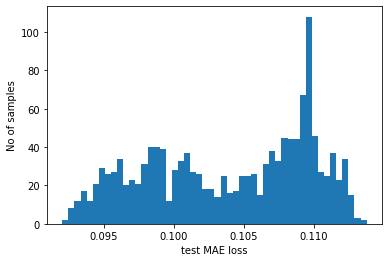

Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)


In [37]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(out_sample)
y_out = out_sample["Industry Expected Losses"].copy()

test_val = normalize_test(y_out, training_mean, training_std)
test_value = normalize_test(test_value, training_mean, training_std)

plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


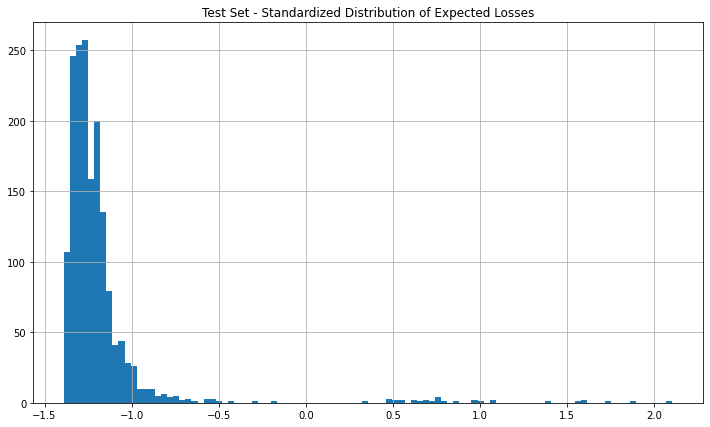

In [38]:
test_val.hist(bins=100, figsize=(12,7))
plt.title("Test Set - Standardized Distribution of Expected Losses")
plt.show()


**Alternative 1D Conv. Layer: Still Under Study**

In [49]:
alt_model = keras.models.Sequential()
alt_model.add(keras.layers.InputLayer(input_shape=[x_train.shape[1], x_train.shape[2]]))
#alt_model.add(keras.layers.InputLayer(input_shape=[288, 1]))


for rate in (1, 2, 4, 8) * 2:
  alt_model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                activation="relu", dilation_rate=rate))

alt_model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
alt_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

alt_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 288, 20)           60        
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 288, 20)           820       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 288, 20)           820       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 288, 20)           820       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 288, 20)           820       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 288, 20)           820       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 288, 20)          

In [50]:
alt_history = alt_model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
10/10 [==============================] - 2s 177ms/step - loss: 1.0362 - val_loss: 0.4698
Epoch 2/50
10/10 [==============================] - 2s 154ms/step - loss: 0.9587 - val_loss: 0.4772
Epoch 3/50
10/10 [==============================] - 2s 153ms/step - loss: 0.7952 - val_loss: 0.4601
Epoch 4/50
10/10 [==============================] - 2s 161ms/step - loss: 0.6208 - val_loss: 0.4050
Epoch 5/50
10/10 [==============================] - 2s 156ms/step - loss: 0.4053 - val_loss: 0.3425
Epoch 6/50
10/10 [==============================] - 2s 158ms/step - loss: 0.2577 - val_loss: 0.3014
Epoch 7/50
10/10 [==============================] - 2s 228ms/step - loss: 0.1939 - val_loss: 0.2601
Epoch 8/50
10/10 [==============================] - 3s 285ms/step - loss: 0.1480 - val_loss: 0.2202
Epoch 9/50
10/10 [==============================] - 3s 285ms/step - loss: 0.1114 - val_loss: 0.1496
Epoch 10/50
10/10 [==============================] - 3s 298ms/step - loss: 0.0742 - val_loss: 0.0744

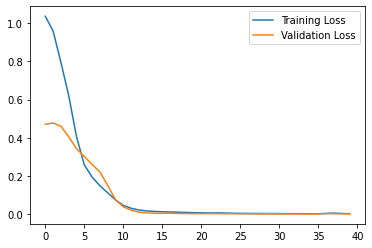

In [52]:
plt.plot(alt_history.history["loss"], label="Training Loss")
plt.plot(alt_history.history["val_loss"], label="Validation Loss")
plt.legend()

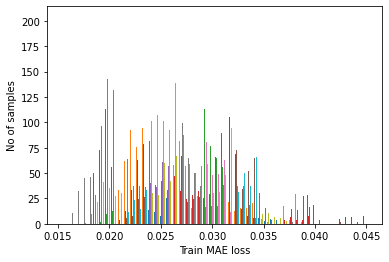

Reconstruction error threshold:  0.04511590505692928


In [53]:
# Get train MAE loss.
x_train_pred_alt = alt_model.predict(x_train)
train_mae_loss_alt = np.mean(np.abs(x_train_pred_alt - x_train), axis=1)

plt.hist(train_mae_loss_alt, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
alt_threshold = np.max(train_mae_loss_alt)
print("Reconstruction error threshold: ", alt_threshold)

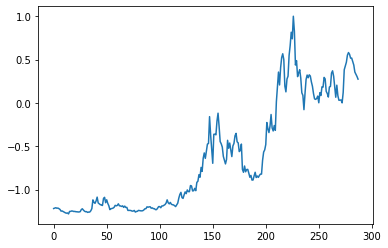

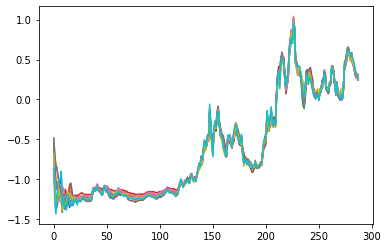

In [54]:
plt.plot(x_train[0])
plt.show()
plt.plot(x_train_pred_alt[0])
plt.show()

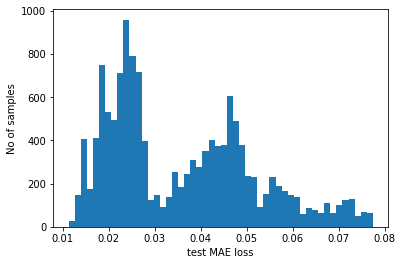

Number of anomaly samples:  4241
Indices of anomaly samples:  (array([    1,     3,     6, ..., 13851, 13853, 13856]),)


In [55]:
# Get test MAE loss.
x_test_pred_alt = alt_model.predict(x_test)
test_mae_loss_alt = np.mean(np.abs(x_test_pred_alt - x_test), axis=1)
test_mae_loss_alt = test_mae_loss_alt.reshape((-1))

plt.hist(test_mae_loss_alt, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
alt_anomalies = (test_mae_loss_alt > alt_threshold).tolist()
print("Number of anomaly samples: ", np.sum(alt_anomalies))
print("Indices of anomaly samples: ", np.where(alt_anomalies))
